In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.measurements import Measurement
from qdev_wrappers.fitting.fitters import CosineFitter
from qdev_wrappers.fitting.plotting import plot_fit_by_id
from qdev_wrappers.fitting.helpers import make_json_metadata

/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/logger.py:16: UserWarning: The logger.py of qdev-wrappers is deprecated and will be removed soon. Please use the logger of QCoDeS instead.
  warnings.warn('The logger.py of qdev-wrappers is deprecated and will be '


To give an example of some code that would create a 'fit' dataset of the type that could be plotted with plot_fit_by_id. However of course you are free to use the fitter in whatever way pleases you and your regular fave plot_by_id will work it's magic as usual.

The main take home is that it's "nice" to have 1 dataset for your data and 1 for your fit results. Thats 2 datasets in total (1 + 1 = 2)

## Least Squares Fitter Example

In [2]:
fitter = CosineFitter()

In [3]:
# create 'data' measurement and register parameters
meas = Measurement()

meas.register_custom_parameter(name='power',
                               label='Power',
                               unit='dBm')

meas.register_custom_parameter(name='pulse_duration',
                               label='Pulse Duration',
                               unit='s')

meas.register_custom_parameter(name='cavity_response',
                               label='Cavity Response',
                               unit='V', 
                               setpoints=('pulse_duration', 'power'))

# create 'fit' measurement and register parameters
analysis = Measurement()

analysis.register_custom_parameter(name='power',
                                   label='Power',
                                   unit='dBm')
for param in fitter.all_parameters:
    analysis.register_parameter(param, setpoints=('power', ))

Now we run both measurements simultaneously and fill up the datasets :) The main thing to note is that the analysis dataset needs metadata about which fitter was used and which data was used. Helpfully there's a helper funciton for this. 

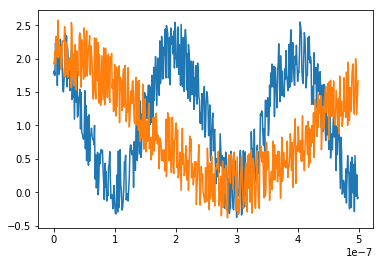

In [4]:
# make some fake data and check it looks readonable
powers = np.arange(20) * -0.5
pulse_durations = np.arange(500) * 1e-9
cavity_responses = []
for p in powers:
    w = np.sqrt(10**((p - 30) / 10)) * 1e9
    cavity_response = fitter.evaluate(pulse_durations, 1., w, 0., 1e-3) + np.random.random(500) + 0.6
    cavity_responses.append(cavity_response)
plt.plot(pulse_durations, cavity_responses[0])
plt.plot(pulse_durations, cavity_responses[-1])

In [5]:
dependent_parameter_name = 'cavity_response'
independent_parameter_name = 'pulse_duration'

with meas.run() as datasaver, analysis.run() as fitsaver:

    # create and add metadata
    metadata = make_json_metadata(datasaver._dataset,
                                  fitter,
                                  dependent_parameter_name,
                                  independent_parameter_name)
    fitsaver.dataset.add_metadata(*metadata)
        
        
    # measurement as normal, plus fitting
    for i, power in enumerate(powers):
        for j, pulse_dur in enumerate(pulse_durations):
            datasaver.add_result(('power', power),
                                 ('pulse_duration', pulse_dur),
                                 ('cavity_response', cavity_responses[i][j]))
        fitter.fit(cavity_responses[i], pulse_durations)
        fit_result = [('power', power)]
        for fit_param in fitter.all_parameters:
            fit_result.append((fit_param.name, fit_param()))
        fitsaver.add_result(*fit_result)

    data_run_id = datasaver.run_id
    fit_run_id = fitsaver.run_id

Starting experimental run with id: 22
Starting experimental run with id: 23


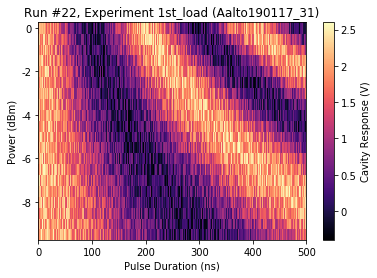

In [6]:
ax, clb = plot_by_id(data_run_id)

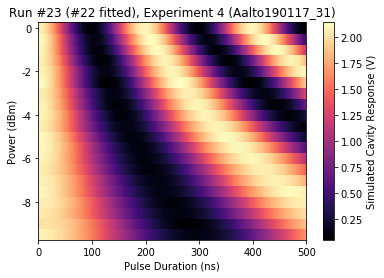

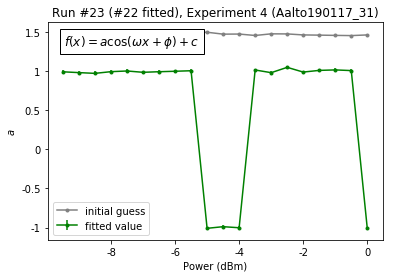

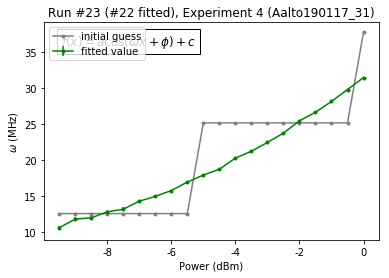

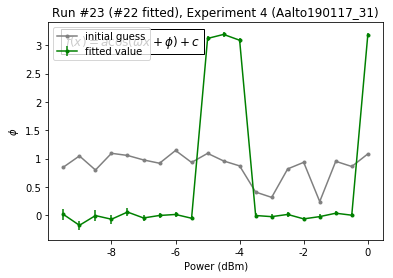

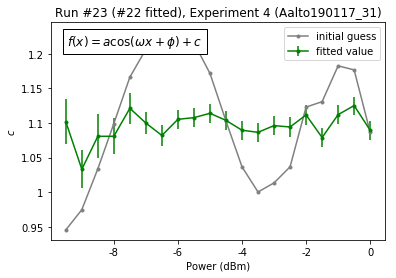

In [7]:
ax, clb = plot_fit_by_id(fit_run_id)